## Data Loading, Imports, and Functions

This sections contains all the intial imports and sets up the ability to imnport the dataset classes from the data processing file.

In [ ]:
# MOUNT DRIVE A THE FOLDER DIRECTORY
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### CHANGE THE `cd` PATH TO WHATEVER DIRECTORY THE MODEL FOLDER IS IN

In [ ]:
# for Cairo
%cd "drive/MyDrive/APS360 Project /Model"

# for Kate
#%cd "/content/drive/MyDrive/APS360/Project /Model"
%pwd

/content/drive/.shortcut-targets-by-id/1iAsHu75MZqQi03g8IZnF4UG6jJs-pJjE/Project /Model


'/content/drive/.shortcut-targets-by-id/1iAsHu75MZqQi03g8IZnF4UG6jJs-pJjE/Project /Model'

In [ ]:
from utils import ImageDataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython import display

from skimage.io import imread
import skimage.io

### Initialize Datasets

In [ ]:
t = transforms.Compose([transforms.ToTensor(), transforms.Resize((450, 450))])

train_dataset = ImageDataset(
   name='Train',
   csv_file='training_data_onehot.csv',
   root_dir='Ham10000',
   transforms= t
)

validation_dataset = ImageDataset(
   name='Validation',
   csv_file='validation_data_onehot.csv',
   root_dir='Ham10000',
   transforms= t
)

test_dataset = ImageDataset(
   name='Test',
   csv_file='test_data_onehot.csv',
   root_dir='HIBA Images - Test',
   transforms= t
)

### Define Training Function

In [ ]:
def training_curve(epochs, train_acc, train_losses, val_acc, val_losses):
    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


def train(model, train_set, val_set, num_epochs=1, learning_rate=1e-4, batch_size=64, weight_decay=0, patience=0, plot=True, print_batches=False):
    # get loaders with the appropriate batch size
    print('Getting Train Loaders')
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    # Accumulators
    epochs = []

    # Training Accumulators
    train_losses = []
    train_accs = []

    # Validation Accumulators
    val_losses = []
    val_accs = []

    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate)

    try:
      start_time = time.time()
      print('Training Start')
      for epoch in range(num_epochs):
          # for progress tracking
          train_batch_num = 0
          val_batch_num = 0

          # for accuracy calc
          train_correct_predictions = 0
          val_correct_predictions = 0
          train_num_images = 0
          val_num_images = 0

          # Clears training output
          display.clear_output(wait=True)

          # Printing graph and results at the start of each epoch so its visable throughout training
          for i in range(len(epochs)):
            print((f"Epoch {epochs[i] + 1}: Train Accuracy: {round(train_accs[i]*100, 6)}% | Valication Accuracy: {round(val_accs[i]*100, 6)}%"))

          # Attempting to implement dynamic plotting
          if plot:
            training_curve(epochs, train_accs, train_losses, val_accs, val_losses)
            display.display(plt.gcf())

          for data in train_loader:
              train_batch_start = time.time()
              train_batch_num += 1

              images, diagnosis, ben_or_mal = data

              #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                images = images.cuda()
                diagnosis = diagnosis.cuda()
                ben_or_mal = ben_or_mal.cuda()
              #############################################


              train_num_images += len(images)

              outputs = model(images)

              prediction = outputs.max(1, keepdim=True)[1]
              train_correct_predictions += prediction.eq(diagnosis.max(1, keepdim=True)[1].view_as(prediction)).sum().item()
              train_acc = train_correct_predictions/train_num_images # calculate overall accuracy


              train_loss = criterion(outputs, diagnosis)
              train_loss.backward()

              optimizer.step()
              optimizer.zero_grad()

              train_batch_end = time.time()

              if print_batches:
                print(f'\nT{train_batch_num}: Training Accuracy: {round(float(train_acc)*100, 2)}%')
                print(f'T{train_batch_num}: Training Loss: {round(float(train_loss), 2)}')

          for data in val_loader:
              val_batch_start = time.time()
              val_batch_num += 1

              images, diagnosis, ben_or_mal = data

              #############################################
              #To Enable GPU Usage
              if use_cuda and torch.cuda.is_available():
                images = images.cuda()
                diagnosis = diagnosis.cuda()
                ben_or_mal = ben_or_mal.cuda()
              #############################################

              val_num_images += len(images)

              outputs = model(images)

              prediction = outputs.max(1, keepdim=True)[1]
              val_correct_predictions += prediction.eq(diagnosis.max(1, keepdim=True)[1].view_as(prediction)).sum().item()
              val_acc = val_correct_predictions/val_num_images # calculate overall accuracy


              val_loss = criterion(outputs, diagnosis)

              val_batch_end = time.time()

              if print_batches:
                print(f'\nV{val_batch_num}: Validation Accuracy: {round(float(val_acc)*100, 2)}%')
                print(f'V{val_batch_num}: Validation Loss: {round(float(val_loss), 2)}')

          # Data Accumulation & Reporting
          epochs.append(epoch)

          train_losses.append(float(train_loss)/batch_size)
          train_accs.append(train_acc)

          val_losses.append(float(val_loss)/batch_size)
          val_accs.append(val_acc)

          print((f"\nEpoch {epoch + 1}: Train Accuracy: {round(train_accs[epoch]*100, 6)}% | Valication Accuracy: {round(val_accs[epoch]*100, 6)}%"))

        # Saving current model
        # model_path =  f'Saved Models/Autoencoder Models/model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch + 1}'
        # torch.save(model.state_dict(), model_path)

        # Implementing early stopping with patience mechanism
          val_loss_counter = 0
          if epoch > 2 and (val_losses[-1] > val_losses[-2] or val_losses[-1] > val_losses[-3]):
            val_loss_counter += 1
          elif epoch > 2 and (val_losses[-1] <= val_losses[-2] or val_losses[-1] <= val_losses[-3]):
            val_loss_counter = 0

          print(f'Early Stop Counter: {val_loss_counter}')

          if val_loss_counter >= patience:
            print(f'Training Stopped Early due to Patience at Epoch {epoch + 1}')
            break
    except KeyboardInterrupt:
        model_path =  f'Saved Models/Autoencoder Models/model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epochs[-1] + 1}'
        torch.save(model.state_dict(), model_path)

        end_time = time.time()

        display.clear_output(wait=True)

        epochs_completed = epochs[-1] + 1

        if plot:
          training_curve(epochs, train_accs, train_losses, val_accs, val_losses)
        print(f'\nNumber of Epochs: {epochs_completed}')
        print(f'Training Time Ellapsed: {round((end_time - start_time)/60, 2)} minutes')
        print(f"Training Accuracy Results: {train_accs[-1]*100}")
        print(f"Validation Accuracy Results: {val_accs[-1]*100}")

        dataframe = pd.DataFrame()
        dataframe.insert(loc=0, column='epochs', value=epochs)
        dataframe.insert(loc=1, column='train_loss', value=train_losses)
        dataframe.insert(loc=2, column='val_loss', value=val_losses)
        dataframe.insert(loc=3, column='tran_acc', value=train_accs)
        dataframe.insert(loc=4, column='val_acc', value=val_accs)

        return dataframe, epochs_completed

    # If model goes to completion, it does the same thing
    model_path =  f'Saved Models/Autoencoder Models/model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch + 1}'
    torch.save(model.state_dict(), model_path)

    end_time = time.time()

    display.clear_output(wait=True)

    epochs_completed = epochs[-1] + 1

    if plot:
      training_curve(epochs, train_accs, train_losses, val_accs, val_losses)

    print(f'\nNumber of Epochs: {epochs_completed}')
    print(f'\nTraining Time Ellapsed: {round((end_time - start_time)/60, 2)} minutes')
    print(f"Training Accuracy Results: {train_accs[-1]*100}")
    print(f"Validation Accuracy Results: {val_accs[-1]*100}")

    dataframe = pd.DataFrame()
    dataframe.insert(loc=0, column='epochs', value=epochs)
    dataframe.insert(loc=1, column='train_loss', value=train_losses)
    dataframe.insert(loc=2, column='val_loss', value=val_losses)
    dataframe.insert(loc=3, column='tran_acc', value=train_accs)
    dataframe.insert(loc=4, column='val_acc', value=val_accs)

    return dataframe, epochs_completed


## Convolutional Autoencoder Models


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = 'AutoencoderC'
        self.encoder = nn.Sequential(
            nn.Conv2d(3,50,5, stride=2, padding=1), # 224 x 224 x 50
            nn.ReLU(),
            nn.Conv2d(50,100,5, stride=2, padding=1), # 111 x 111 x 100
            nn.ReLU(),
            nn.Conv2d(100,150,5, stride=2, padding=1) # 55 x 55 x 150
        )
        self.decoder = nn.Sequential( # decoder is built opposite of the encoder
            nn.ConvTranspose2d(150,100,5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(100,50,5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(50,3,8, stride=2, padding=1),
            nn.Sigmoid() # get to the range (0, 1) which is the kind of data that would be input into the encoder
        )
        self.fc1 = nn.Linear(3*450*450, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 7)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        x = decoded.view(-1, 3*450*450)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x.squeeze(1)
        return x

In [ ]:
class AutoEncoderSimplifiedSkip(nn.Module):
    def __init__(self, dropout):
        super(AutoEncoderSimplifiedSkip, self).__init__()
        self.name = 'AutoEncoderSimplifiedSkip'

        self.encoder1 = nn.Conv2d(3,50,5, stride=3, padding=2) # 150 x 150 x 50
        self.encoder2 = nn.Conv2d(50,100,5, stride=3, padding=2) # 50 x 50 x 100

        self.decoder1 = nn.ConvTranspose2d(100,50,5, stride=3, padding=1) # 150 x 150 X 50
        self.decoder2 = nn.ConvTranspose2d(50,3,5, stride=3, padding=1) # 450 x 450 x 3

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(3*450*450, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 7)
        )

    def forward(self, x):
        encoder1 = F.relu(self.encoder1(x))
        encoder2 = F.relu(self.encoder2(encoder1))

        decoder1 = encoder1 + F.relu(self.decoder1(encoder2))
        decoder2 = F.sigmoid(x + F.relu(self.decoder2(decoder1)))

        x = decoder2.view(-1, 3*450*450)
        x = self.classifier(x)
        x.squeeze(1)
        return x

In [ ]:
class AutoEncoderSimplifiedSkipFC(nn.Module):
    def __init__(self, dropout):
        super(AutoEncoderSimplifiedSkipFC, self).__init__()
        self.name = 'AutoEncoderSimplifiedSkipFC'

        self.encoder1 = nn.Conv2d(3,50,5, stride=3, padding=2) # 150 x 150 x 50
        self.encoder2 = nn.Conv2d(50,100,5, stride=3, padding=2) # 50 x 50 x 100

        self.decoder1 = nn.ConvTranspose2d(100,50,5, stride=3, padding=1) # 150 x 150 X 50
        self.decoder2 = nn.ConvTranspose2d(50,3,5, stride=3, padding=1) # 450 x 450 x 3

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(3*450*450, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 7)
        )

    def forward(self, x):
        encoder1 = F.relu(self.encoder1(x))
        encoder2 = F.relu(self.encoder2(encoder1))

        decoder1 = encoder1 + F.relu(self.decoder1(encoder2))
        decoder2 = F.sigmoid(F.relu(self.decoder2(decoder1)))

        x = decoder2.view(-1, 3*450*450)
        x = self.classifier(x)
        x.squeeze(1)
        return x

In [ ]:
class AutoEncoderDeepSkip(nn.Module):
    def __init__(self, dropout):
        super(AutoEncoderDeepSkip, self).__init__()
        self.name = 'AutoEncoderDeepSkip'

        self.encoder1 = nn.Conv2d(3,25,5, stride=3, padding=1) # 150 x 150 x 50
        self.encoder2 = nn.Conv2d(25,50,5, stride=3, padding=2) # 50 x 50 x 100
        self.encoder3 = nn.Conv2d(50,75,5, stride=3, padding=1) # 16 x 16 x 150

        self.decoder1 = nn.ConvTranspose2d(75,50,5, stride=3, padding=0) # 50 x 50 X 100
        self.decoder2 = nn.ConvTranspose2d(50,25,5, stride=3, padding=1) # 150 x 150 x 50
        self.decoder3 = nn.ConvTranspose2d(25,3,5, stride=3, padding=1) # 450 x 450 x 3

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(3*450*450, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 7)
        )

    def forward(self, x):
        encoder1 = F.relu(self.encoder1(x))
        encoder2 = F.relu(self.encoder2(encoder1))
        encoder3 = F.relu(self.encoder3(encoder2))

        decoder1 = encoder2 + F.relu(self.decoder1(encoder3))
        decoder2 = encoder1 + F.relu(self.decoder2(decoder1))
        decoder3 = F.sigmoid (x + F.relu(self.decoder3(decoder2)))

        x = decoder3.view(-1, 3*450*450)
        x = self.classifier(x)
        x.squeeze(1)
        return x

## Training Model

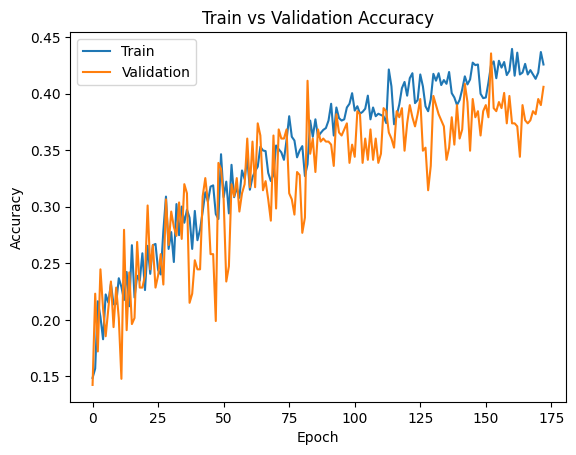

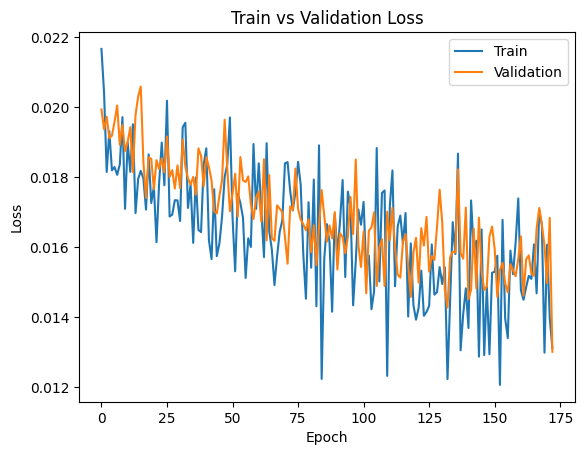


Number of Epochs: 173
Training Time Ellapsed: 105.06 minutes
Training Accuracy Results: 42.56607929515418
Validation Accuracy Results: 40.59139784946236


In [ ]:
dropout = 0.05
model = AutoEncoderDeepSkip(dropout)

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

num_epochs = 400
batch_size = 100
learning_rate = 1e-5
weight_decay = 1e-3
patience = 3

training_values, epochs_completed = train(model, train_dataset, validation_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, patience=patience)

## Testing Model


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test_model(model, test_dataset, batch_size):
    print('Fetching Loader')
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # for accuracy calc
    correct_predictions = 0
    num_images = 0

    # for confustion matrix
    predictions = []
    labels = []

    batch_num = 0
    for i, data in enumerate(test_loader, 0):
        batch_num += 1
        print(f'Batch Number: {batch_num}')
        images, diagnosis, ben_or_mal = data

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          images = images.cuda()
          diagnosis = diagnosis.cuda()
          ben_or_mal = ben_or_mal.cuda()
        #############################################

        num_images += len(images)

        # get output from model
        outputs = model(images)


        # Model Prediction
        prediction = outputs.max(1, keepdim=True)[1]
        predictions.extend(prediction.cpu().numpy())

        # Ground Truth Label
        label = diagnosis.max(1, keepdim=True)[1]
        labels.extend(label.cpu().numpy())

        correct_predictions += prediction.eq(label.view_as(prediction)).sum().item()

    acc = correct_predictions/num_images # calculate overall accuracy
    print(f"\nOverall Accuracy: {acc*100}%")

    return acc, predictions, labels

def plot_cm(labels, predictions, test_dataset):
    cm = confusion_matrix(labels, predictions)
    cm_matrix = pd.DataFrame(data=cm,
        columns=[f'Predicted {diag}' for diag in test_dataset.column_values['diagnosis']],
        index=[f'Actual {diag}' for diag in test_dataset.column_values['diagnosis']]
    )

    m = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
    m.set_xticklabels(m.get_xticklabels(), rotation = 35, horizontalalignment='right')
    return m, cm_matrix

In [ ]:
good_model = AutoEncoderDeepSkip(dropout)
good_model_path = f"Saved Models/Autoencoder Models/model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epochs_completed}"

use_cuda = True

if use_cuda and torch.cuda.is_available():
  saved_state = torch.load(good_model_path)
  good_model.load_state_dict(saved_state)
  good_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  saved_state = torch.load(good_model_path, map_location=torch.device('cpu'))
  good_model.load_state_dict(saved_state)

test_acc, prediction, labels = test_model(good_model, test_dataset, batch_size=batch_size)


CUDA is available!  Training on GPU ...
Fetching Loader


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Batch Number: 1
Batch Number: 2
Batch Number: 3

Overall Accuracy: 27.62237762237762%


Test Accuracy of Saved Models/Autoencoder Models/model_AutoEncoderDeepSkip_bs100_lr1e-05_epoch173: 27.62237762237762
              precision    recall  f1-score   support

           0       0.07      0.21      0.11        14
           1       0.51      0.40      0.45        72
           2       0.08      0.12      0.10         8
           3       0.35      0.13      0.19        54
           4       0.40      0.34      0.37       106
           5       0.10      0.12      0.11        25
           6       0.00      0.00      0.00         7

    accuracy                           0.28       286
   macro avg       0.22      0.19      0.19       286
weighted avg       0.36      0.28      0.30       286



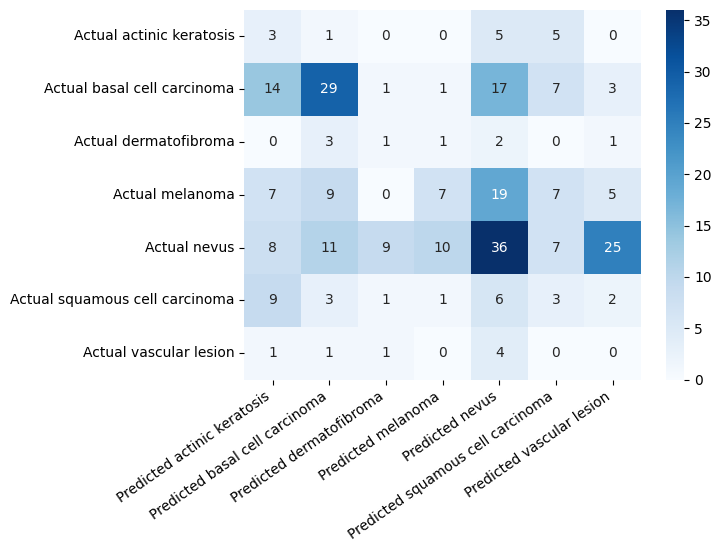

In [ ]:
from sklearn.metrics import classification_report
print(f'Test Accuracy of {good_model_path}: {test_acc*100}')
heat_map, cm_matrix = plot_cm(labels, prediction, test_dataset)

print(classification_report(labels, prediction))